In [2]:
import os
import json
import time
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from io import StringIO
from datetime import datetime
import glob
from dotenv import load_dotenv

In [2]:
# ----------------------- Note
# Common variables to defined before any script run

# API Keys provided by PurpleAir(c)
key_read  = '6CF9C562-6AEB-11EF-95CB-42010A80000E'

# Sleep Seconds
sleep_seconds = 3 # wait sleep_seconds after each query

# Data download period. Enter Start and end Dates
bdate = '2021-01-01T00:00:00+00:00' 
edate = '2021-01-12T00:00:00+00:00'

# Average_time. The desired average in minutes, one of the following: 0 (real-time), 
# 10 (default if not specified), 30, 60, 360 (6 hour), 1440 (1 day)
average_time=10 # or 10  or 0 (Current script is set only for real-time, 10, or 60 minutes data)

data_dir = "data"
processed_dir = "processed"

In [3]:
# Load environment variables from .env file
load_dotenv()

# # Access environment variables
# key_read = os.getenv('KEY_READ')
# sleep_seconds = int(os.getenv('SLEEP_SECONDS'))
# average_time = int(os.getenv('AVERAGE_TIME'))
# data_dir = os.getenv('DATA_DIR')
# processed_dir = os.getenv('PROCESSED_DIR')

False

In [4]:
# Function to update the log file with the last download date and sensor info
def update_sensor_index_log(log_file_path, sensor_list, last_download_date):
    log_data = {}

    # Check if the log file exists, and load existing data if available
    if os.path.exists(log_file_path):
        with open(log_file_path, 'r') as log_file:
            log_data = json.load(log_file)

    # Update the log with the last download date
    log_data["sensors_index.csv file last updated"] = str(last_download_date)
    log_data["sensors_skipped"] = []

    # Add or update each sensor in the log
    for sensor in sensor_list:
        if str(sensor) not in log_data:
            log_data[str(sensor)] = {
                "min_date": None,
                "max_date": None,
                "url_issue": [],
                "no_data": []
            }
    
    # Write the updated log to a JSON file
    with open(log_file_path, 'w') as log_file:
        json.dump(log_data, log_file, indent=4)
    
    print(f"{log_file_path} successfully updated.")

In [5]:
# Function to get sensors from the API
def get_sensors(key_read, filename = "sensors_index"):
    
    '''
    Parameters:

    key_read (string): The API key required to access the PurpleAir API.
    filename (string, optional): The name of the output CSV file (default: "sensors_index").
    
    Returns:
    
    The GeoDataFrame containing the sensor data along with the us flag
    
    Detailed Steps:

    1. Define API URL: The function builds a URL to request sensor data from the PurpleAir API, specifying fields like name, location_type, latitude, longitude, and other sensor metadata.
    2. API Call: The function sends a GET request to the API using the constructed URL. If the request is successful (status_code = 200), it loads the JSON response and converts it into a pandas DataFrame. If the request fails, it raises an exception with an error description.
    3. Data Cleaning: Converts UNIX timestamps (last_modified, date_created, last_seen) into a human-readable date format.
    4. Check U.S. Sensors: 
            a. Converts the sensor data into a GeoDataFrame using the latitude and longitude of the sensors.
            b. Loads a GeoJSON file containing U.S. boundaries.
            c. Ensures both datasets share the same coordinate reference system (CRS).
            d. Performs a spatial join to flag sensors that are located in the U.S. (us = 1 if in the U.S., us = 0 otherwise).
    5. Saving Data:
            a. Cleans up unnecessary columns from the GeoDataFrame.
            b. Ensures the target directory for saving the file exists.
            c. Saves the cleaned sensor data as a CSV file.
    6. Logging:
            a. Extracts the list of sensor indices.
            b. Updates a log file (sensor_log.json) with the sensor list and the current date.
    '''
    
    # PurpleAir API URL
    root_url = 'https://api.purpleair.com/v1/sensors/'
    
    # fields to get
    fields_list = ['name', 'location_type', 'latitude', 'longitude', 'altitude', 
                   'position_rating', 'uptime', 'last_seen', 'last_modified', 'date_created']
    
    # Build the fields parameter for the API call
    fields_api_url = '&fields=' + '%2C'.join(fields_list)
    
    # Final API URL
    api_url = root_url + f'?api_key={key_read}' + fields_api_url
    
    print(api_url)
    
    # Getting data
    response = requests.get(api_url)
    if response.status_code == 200:
        json_data = json.loads(response.content)
        df = pd.DataFrame.from_records(json_data["data"])
        df.columns = json_data["fields"]
    else:
        json_data = json.loads(response.content)
        print("Error description:", json_data["description"])
        raise requests.exceptions.RequestException("Failed to fetch sensor data.")
    
    # ----------------------- clean sensor index df
    # Convert UNIX timestamps to readable date format
    df['last_modified'] = pd.to_datetime(df['last_modified'], unit='s')
    df['date_created'] = pd.to_datetime(df['date_created'], unit='s')
    df['last_seen'] = pd.to_datetime(df['last_seen'], unit='s')
    
    # ----------------------- create new column 'us': us = 1 if a sensor is in US; otherwise = 0
    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs=4326)

    # Load U.S. boundaries from a GeoJSON file
    us_shp = gpd.read_file(os.path.join(data_dir, "us_shp.json"))

    # Ensure the CRS matches
    us_shp.to_crs(gdf.crs, inplace=True)

    # Perform a spatial join to check if the points are in the U.S.
    gdf_us = gpd.sjoin(gdf, us_shp, how="left", predicate="intersects")

    # Add 'us' flag: if the point is in the U.S.
    gdf_us['us'] = gdf_us['index_right'].notnull().astype(int)

    # Drop unnecessary columns
    gdf_sensors = gdf_us.drop(columns=['index_right', 'AFFGEOID', 'GEOID', 'NAME'])

    # Directory to store the file
    os.makedirs(processed_dir, exist_ok=True)  # Create directory if it doesn't exist
    
    filename = os.path.join(processed_dir, filename + ".csv")
    
    print(filename)
    # Define file path and save the CSV file
    gdf_sensors.to_csv(filename, index=False, header=True)

    print(f"{len(gdf_sensors)} sensors successfully extracted and stored in: {filename}")

    # extract sensor_list
    sensor_list = gdf_sensors['sensor_index'].tolist()
    
    # Update the download log
    today = datetime.now().date()

    log_file_path = 'sensor_log.json'
    update_sensor_index_log(log_file_path, sensor_list, today)
    
    return gdf_sensors

In [6]:
def get_sensorslist(filename = "sensors_index"):
    """Retrieve sensor indexes based on whether they are US or not."""
    
    if os.path.exists(os.path.join(processed_dir, filename + '.csv')):
        sensors_index = pd.read_csv(os.path.join(processed_dir, filename + '.csv'))
    else:
        # call get_sensors to new lists of sensor
        sensors_index = get_sensors(key_read = key_read, filename=filename)
        
    # replace this with get_sensor function later!
    # all_sensorlist = gdf_sensorlist['sensor_index'].tolist()
        
    # subset us_indoor and us_oudoor sensors
    # us_sensorlist = sensors_index[sensors_index['us'] == 1]['sensor_index'].tolist()
    us_indoor_sensorlist = sensors_index[(sensors_index['us'] == 1) & (sensors_index['location_type'] == 1)]['sensor_index'].tolist()
    us_outdoor_sensorlist = sensors_index[(sensors_index['us'] == 1) & (sensors_index['location_type'] == 0)]['sensor_index'].tolist()
    
    # non_us_indoor and non_us_outdoor sensors
    nonus_sensorlist = sensors_index[sensors_index['us'] == 0]['sensor_index'].tolist()

    sensor_dict = {
        "us_indoor": us_indoor_sensorlist, 
        "us_outdoor": us_outdoor_sensorlist,
        "non_us": nonus_sensorlist
        }
    
    return sensor_dict

In [7]:
def calculate_pa_points(n_sensors, begin_time, end_time):
    
    # point each request
    # rows = 714
    # columns = 8 + 2
    # point_per_request = int(rows*columns)
    
    point_per_request = 5738
    
    # find number of days from begin_time: 01-01-2021 to end_time: 12:31:2023
    # Convert strings to datetime objects
    begin_date = datetime.strptime(begin_time, '%m-%d-%Y')
    end_date = datetime.strptime(end_time, '%m-%d-%Y')

    # Calculate the difference in days
    n_days = (end_date - begin_date).days
    print(n_days)
    
    total_points_per_sensor = (n_days/5)*point_per_request
    
    total_points_n_sensors = int(total_points_per_sensor) * int(n_sensors)
    
    return int(total_points_n_sensors)

In [54]:
def create_pa_datelist(average_time, bdate, edate):
    """Create a list of date ranges for the historical data period."""
    
    # Dates of Historical Data period
    # begindate = datetime.fromisoformat(bdate)
    # enddate = datetime.fromisoformat(edate)
    begindate = datetime.strptime(bdate, '%Y-%m-%d') 
    enddate = datetime.strptime(edate, '%Y-%m-%d') 
    
    # Download days based on average
    if average_time == 60:
        datelist = pd.date_range(begindate, enddate, freq='14d')  # 14 days of data
    else:
        datelist = pd.date_range(begindate, enddate, freq='5d')   # 5 days of data

    # Reverse to get data from end date to start date
    datelist = datelist.tolist()
    datelist.reverse()
    
    # Convert to required format
    date_list = [dt.strftime('%Y-%m-%dT%H:%M:%SZ') for dt in datelist]
    
    return date_list

In [9]:
def get_historicaldata(sensors_list, 
                       bdate, 
                       edate, 
                       average_time, 
                       data_dir, 
                       processed_dir, 
                       key_read, 
                       sleep_seconds):
    """
    Purpose:

    This function downloads historical sensor data from the PurpleAir API for a given list of sensors over a specified date range. It processes the data, stores it in separate files per sensor, and updates a log to track downloaded data.

    Parameters:

    sensors_list (list): List of sensor indices to download data for.
    bdate (string): The beginning date (in ISO format) for the data to be retrieved.
    edate (string): The ending date (in ISO format) for the data to be retrieved.
    average_time (int): The average time (in minutes) used for the sensor data.
    data_dir (string): Directory where indoor sensor data is stored.
    processed_dir (string): Directory to save the downloaded sensor data.
    key_read (string): API key to access PurpleAir API.
    sleep_seconds (int): Time in seconds to wait between consecutive API requests to avoid throttling.
    
    Returns:
    
    Save Data: The processed data for each sensor is saved in the folder with sensor ID, using a filename that includes the sensor ID and the date range.
    Log Updates: After processing each sensor, the log file is updated with information about skipped sensors, missing data, and any errors encountered.

    """
    
    # Load the download log file
    log_file_path = 'sensor_log.json'
    with open(log_file_path, 'r') as log_file:
        log_data = json.load(log_file)
    
    # Historical API URL: for multiple sensors
    root_api_url = 'https://api.purpleair.com/v1/sensors/'
    
    # Average time parameter for API
    average_api = f'&average={average_time}'
    
    # Create the fields API URL
    fields_list = ['pm2.5_atm_a', 'pm2.5_atm_b', 'pm2.5_cf_1_a', 'pm2.5_cf_1_b', 'humidity', 'temperature']
    fields_api_url = '&fields=' + '%2C'.join(fields_list)
    
    print("CHECK POINT 1: Fields API URL")
    print(fields_api_url)
    
    # Retrieve sensor index for us_indoor
    us_indoor_sensors = pd.read_csv(os.path.join(data_dir, "indoor_us_jay.csv"))
    us_indoor_sensorlist_jay = us_indoor_sensors['sensor_index'].tolist()
    
    # Generate date list for all sensors
    date_list = create_pa_datelist(average_time, bdate, edate)
    
    print("CHECK POINT 2: Generated Date List")
    print(date_list)
    
    # Generate date list to skip data for certain us_indoor sensors (from 2021-01-01 to 2023-12-31)
    check_datelist = create_pa_datelist(average_time, '2021-01-01T00:00:00+00:00', '2023-12-31T00:00:00+00:00')
    
    len_datelist = len(date_list) - 1
    
    # Process each sensor
    for sensor in sensors_list:
        
        # create new folder for a sensor
        sensor_folder = os.path.join(processed_dir, f"sensorID_{sensor}")
        os.makedirs(sensor_folder, exist_ok=True)  # Create sensor folder if it doesn't exist
        
        hist_api_url = root_api_url + f'{sensor}/history/csv?api_key={key_read}'
        
        # Check if any file exists in the folder: returns a list of files
        existing_files = glob.glob(f'{sensor_folder}/*.csv')
        
        print("CHECK POINT 3: Existing Files")
        print(existing_files)
        
        # If any file exists, use the latest file
        if existing_files:
            # Read the existing file
            existing_df = pd.read_csv(existing_files[0])
        else:
            print(f"No existing files for sensor {sensor}. Starting new file.")
            existing_df = pd.DataFrame()  # No existing data

        # Create start and end date API URL
        for index, date in enumerate(date_list):
            
            # Throttle API requests
            time.sleep(sleep_seconds)  
            
            if index < len_datelist:
                
                # Skip if sensor is in us_indoor and the date is in 2021-2023
                if sensor in us_indoor_sensorlist_jay and min(check_datelist) <= date <= max(check_datelist):
                    print(str(sensor))
                    # Add sensor to skipped list if not already present
                    if sensor not in log_data["sensors_skipped"]:
                        log_data["sensors_skipped"].append(sensor)
                    print(f"Skipping download for {sensor} from {date_list[index+1]} to {date} (us_indoor sensor already downloaded)")
                    continue

                # Download data for PA
                print(f'Downloading for PA: {sensor} for Dates: {date_list[index+1]} and {date}.')
                dates_api_url = f'&start_timestamp={date_list[index+1]}&end_timestamp={date}'
                
                api_url = hist_api_url + dates_api_url + average_api + fields_api_url
                                    
                try:
                    response = requests.get(api_url)
                    response.raise_for_status()  # Raises an exception for 4xx/5xx responses
                    df = pd.read_csv(StringIO(response.text), sep=",", header=0)
                
                # -------------------------- Note
                # Try break for any API related error 
                # or break when only payment issue with API?
                except requests.exceptions.RequestException as e:
                    try:
                        json_data = json.loads(response.content)
                        if json_data["description"] == "Payment is required to make this api call.":
                            print(json_data["description"])
                            break
                        else: 
                            log_data[str(sensor)]["url_issue"].append(json_data["description"])
                    except:
                        log_data[str(sensor)]["url_issue"].append(f"Request failed: {str(e)}")
                    continue
                
                except pd.errors.EmptyDataError:
                    log_data[str(sensor)]["no_data"].append(f"{date_list[index+1]} to {date}")
                    continue
                
                except Exception as e:
                    print(f"Unexpected error for sensor {sensor}: {e}")
                    continue

                if df.empty:
                    log_data[str(sensor)]["no_data"].append(f"{date_list[index+1]} to {date}")
                    continue
                
                # Process DataFrame
                df['time_stamp'] = pd.to_datetime(df['time_stamp'])
                df = df.drop_duplicates().sort_values(by='time_stamp')

                # Append the new data to the existing DataFrame if it exists
                if not existing_df.empty:
                    df = pd.concat([existing_df, df], ignore_index=True)
                    df['time_stamp'] = pd.to_datetime(df['time_stamp'])
                    df = df.drop_duplicates().sort_values(by='time_stamp')

                # Get the minimum and maximum date from the combined DataFrame
                min_date = df['time_stamp'].min()
                max_date = df['time_stamp'].max()
                
                min_date = min_date.strftime("%Y_%m_%d")
                max_date = max_date.strftime("%Y_%m_%d")
                # date = datetime.strptime(date, "%Y-%m-%dT%H:%M:%SZ")  
                # date = date.strftime("%Y_%m_%d")
                
                try: 
                    # ---------------------- Note:
                    # Should we use .parquet? Parquet file path (corrected extension to .parquet)
                    # For now, testing on csv
                    csv_file = f'{sensor_folder}/sensorID_{sensor}_{min_date}_{max_date}.csv'

                    # Save the dataframe
                    df.to_csv(csv_file, index=False)
                    print(f"Attempting to save data to: {csv_file}")

                    # If saving succeeds, remove the old file
                    if existing_files:
                        os.remove(existing_files[0])
                    
                    print(f"Data is saved to: {csv_file}")
                    
                except Exception as e:
                    print(f"Error saving new file: {e}")
                    
    # Save the updated log file at the end of the process
    with open(log_file_path, 'w') as log_file:
        json.dump(log_data, log_file, indent=4)
    

In [ ]:
# edate = datetime.now().strftime('%Y-%m-%d') + 'T00:00:00+00:00'
# sensors_list = get_sensors(us_indoor=False)
# sample_sensors = [131255, 131365, 469, 53, 77, 182]

# Data download period. Enter Start and end Dates
bdate = '2021-01-01T00:00:00+00:00' 
edate = '2021-01-12T00:00:00+00:00'

# sensors_index = get_sensors(key_read = key_read, filename = "sensors_index")

# sensorslist_dict = get_sensorslist(filename="sensors_index")
# us_indoor_sensorlist = sensorslist_dict["us_indoor"]
# us_outdoor_sensorlist = sensorslist_dict["us_outdoor"]
# nonus_sensorlist = sensorslist_dict["non_us"]

sample_sensors = [131255, 182]

result = get_historicaldata(sensors_list=sample_sensors, 
                       bdate = bdate, 
                       edate = edate, 
                       average_time = average_time, 
                       data_dir = data_dir, 
                       processed_dir = processed_dir, 
                       key_read = key_read, 
                       sleep_seconds = sleep_seconds)

In [10]:
sensors_index = pd.read_csv('processed/sensors_index.csv')
sensors_index.head()

,Unnamed: 0,sensor_index,last_modified,date_created,last_seen,name,location_type,uptime,position_rating,latitude,longitude,altitude,geometry,us
0,0,53,2018-03-02 21:26:22,2016-02-04 01:21:31,2024-09-04 18:26:54,Lakeshore,0,48883.0,5,40.246742,-111.704800,NaN,POINT (-111.7048 40.246742),1
1,1,77,2019-11-30 00:48:27,2016-03-02 05:25:39,2024-09-04 18:27:30,Sunnyside,0,11122.0,5,40.750816,-111.825290,NaN,POINT (-111.82529 40.750816),1
2,2,182,2016-08-12 21:55:12,2016-08-01 20:09:28,2024-09-04 18:26:21,"Jolly Brothers Road, Gabriola Island BC P1",0,53358.0,0,49.160076,-123.742270,NaN,POINT (-123.74227 49.160076),0
3,3,195,2023-08-24 00:33:01,2016-08-01 20:24:44,2024-09-04 18:27:44,"Westhaven Dr N, Trinidad",0,32183.0,5,41.060000,-124.128840,290.0,POINT (-124.12884 41.06),1
4,4,286,2017-01-30 19:25:29,2016-09-06 18:39:46,2024-09-04 16:36:29,Lasqueti Island,0,694.0,0,49.484260,-124.266624,NaN,POINT (-124.266624 49.48426),0


### Sensor data fields

| Field           | Type     | Description                                                                                                  |
|-----------------|----------|--------------------------------------------------------------------------------------------------------------|
| sensor_index    | Integer  | The sensor's index. Can be used to add a sensor to a group or view its details.                               |
| last_modified   | Long     | The UNIX time stamp from the last time the device was modified by the registration form.                      |
| date_created    | Long     | The UNIX time stamp from when the device was created.                                                         |
| last_seen       | Long     | The UNIX time stamp of the last time the server received data from the device.                                |
| name            | String   | The name given to the sensor from the registration form and used on the PA map.                               |
| location_type   | Integer  | The location type. Possible values are: 0 = Outside or 1 = Inside.                                            |
| uptime          | Integer  | The time in minutes since the firmware started as last reported by the sensor.                                |
| position_rating | Integer  | A 'star' rating of position accuracy. 0 stars is nowhere near the claimed location whereas 5 stars is close to the map location as indicated by the latitude and longitude values. |
| latitude        | Number   | The latitude position value for the sensor.                                                                   |
| longitude       | Number   | The longitude position value for the sensor.                                                                  |
| altitude        | Number   | The altitude for the sensor's location in feet.                                                               |
| us              | Binary   | Flag indicator whether the sensor is in us or not                                                             |






In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Create a GeoDataFrame
gdf_sensorlist = gpd.GeoDataFrame(
    sensors_index, 
    geometry=gpd.points_from_xy(sensors_index.longitude, sensors_index.latitude),
    crs=4326   
)

/var/folders/6h/91bwk18d72s6tlckb7tzjsvh0000gn/T/ipykernel_1258/1480947778.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


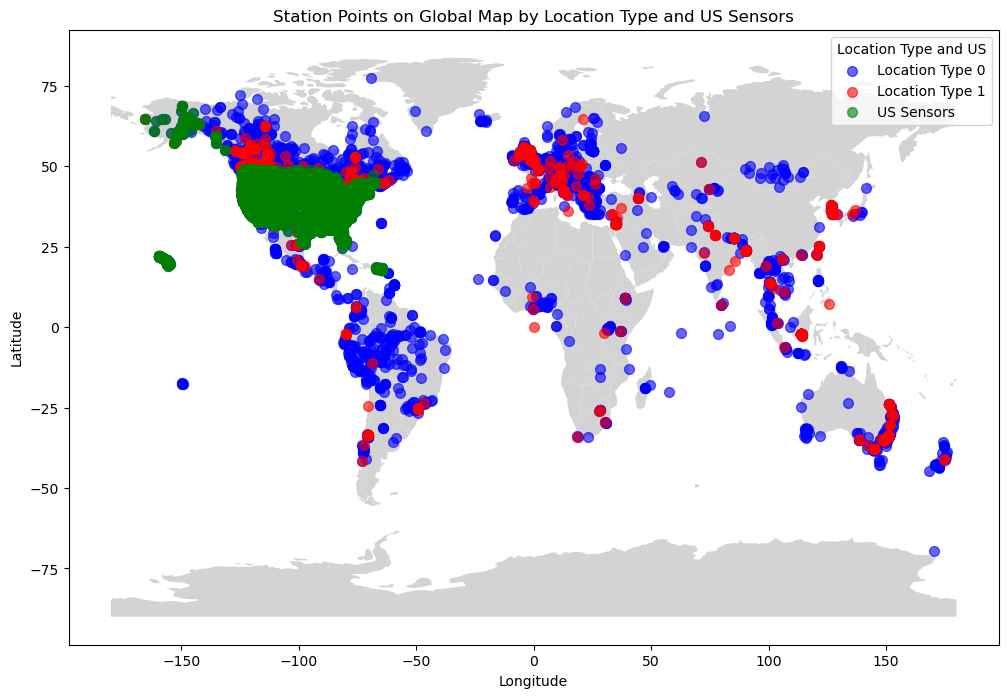

In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load a base map of the world
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Define colors for location types and US sensors
colors = {0: 'blue', 1: 'red'}  # Blue and Red for location types
us_color = 'green'  # Green for US sensors

# Plot the base map
fig, ax = plt.subplots(figsize=(12, 8))
world.plot(ax=ax, color='lightgrey')

# Plot sensor locations by location type
for location_type, color in colors.items():
    subset = gdf_sensorlist[gdf_sensorlist['location_type'] == location_type]
    subset.plot(ax=ax, color=color, markersize=50, alpha=0.6, label=f'Location Type {location_type}')

# Plot sensors in the US
us_sensors = gdf_sensorlist[gdf_sensorlist['us'] == 1]  # Assuming 'us' column is binary: 1 for US, 0 for non-US
us_sensors.plot(ax=ax, color=us_color, markersize=50, alpha=0.6, label='US Sensors')

# Add legend
plt.legend(title='Location Type and US')

# Add titles and labels
plt.title('Station Points on Global Map by Location Type and US Sensors')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

Total number of available sensors: 26841
Most recent sensor created on: 2024-08-27 15:54:11
Oldest sensor created on: 2016-02-04 01:21:31

Available sensors by position rating:
position_rating
2      202
1      332
4      374
3      433
0     5711
5    19789
Name: count, dtype: int64

Available sensors by location type (0 = outdoor, 1 = indoor):
location_type
0    20522
1     6319
Name: count, dtype: int64

Available sensors by the last time of year the server received data from the device:
last_seen
2021        4
2022        4
2023       14
2024    26819
Name: count, dtype: int64


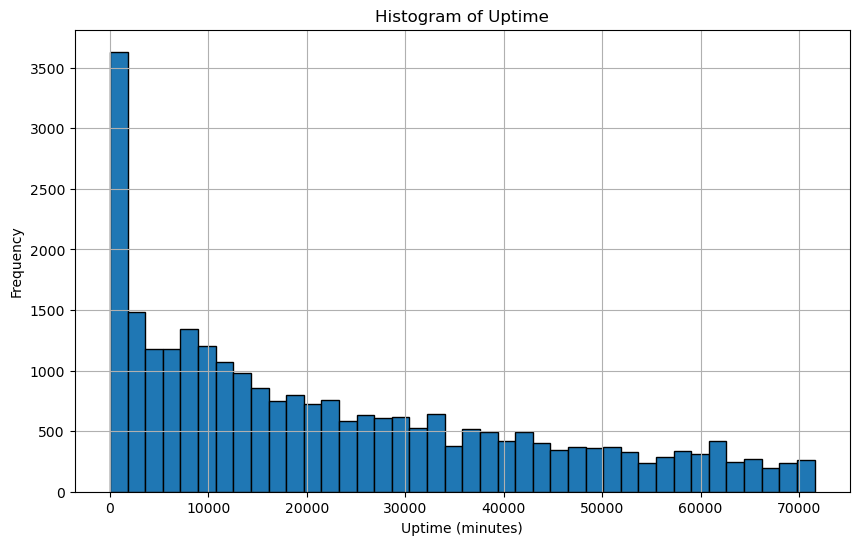

In [13]:
# Display the total number of available sensors
print("Total number of available sensors:", len(sensors_index))

# Display the most recent and oldest sensors based on the 'date_created' timestamp
print("Most recent sensor created on:", pd.to_datetime(max(sensors_index["date_created"])).strftime('%Y-%m-%d %H:%M:%S'))
print("Oldest sensor created on:", pd.to_datetime(min(sensors_index["date_created"])).strftime('%Y-%m-%d %H:%M:%S'))

# Display the available sensors by position rating, sorted by count
print("\nAvailable sensors by position rating:")
print(sensors_index['position_rating'].value_counts().sort_values())

# Display the available sensors by location type (0 = outdoor, 1 = indoor)
print("\nAvailable sensors by location type (0 = outdoor, 1 = indoor):")
print(sensors_index['location_type'].value_counts())

print("\nAvailable sensors by the last time of year the server received data from the device:")
print(pd.to_datetime(sensors_index['last_seen']).dt.strftime('%Y').value_counts().sort_values())

# Create histogram of the 'uptime' column
plt.figure(figsize=(10, 6))
plt.hist(sensors_index['uptime'], bins=40, edgecolor='black')
plt.title('Histogram of Uptime')
plt.xlabel('Uptime (minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

To do list: 
1. do we need sensors that is not in Jay's sensor list?
    - Jay's number of sensors are about 26000. Do we care about matching the current sensors with already downloaded sensors as much as possible or should we download available sensors and match it later?
    - also, based on jay's code, seems like he downloaded only us_indoor sensors data? is that correct? I thought we want to download all sensors across globally?

    - **Answer**: We don’t want to duplicate downloading data Jay already downloaded but we do want to download any available sensor data even if that sensor is not in Jay’s dataset (eg if it came online only recently). Also you’re right both that we want all sensors and that Jay started on US indoor. That was just a way for Jay to order the downloads he was ultimately planning on downloading everything just picked US indoor as the first group and then never got around to other groups.

2. do we need sensors whose position rating is doubtful? 

    - **Answer**: I think we can ignore position_rating for now and download everything. From reading about it that variable sounds like a potentially unreliable measure of position accuracy.
 
3. do we need sensors who stopped communicating to the PA prior years to 2024?

    - **Answer**: Yes in general we want all data from sensors even if they stopped communicating before 2024. That being said I think we can set some filter for minimum time online. Like maybe we only include sensors that were/are online for at least 180 days (~6 months). I don’t think we need to worry about monitors with only a few days of data available. I think we can check this from diff between first_seen and last_seen. Doesn’t need to be perfect.

4. data we have runs from Jan 1, 2021 to Dec 31, 2023. 

(From Jay's work) Prioritization of PA: 

- indoor US
- outdoor US 
- indoor international
- outdoor international

Variable we want: 
- ‘pm2.5_atm_a’
- ‘pm2.5_atm_b’
- ‘pm2.5_cf_1_a’
- ‘pm2.5_cf_1_b’
- ‘humidity’
- ‘temperature’

In [23]:
sensors_dict = get_sensorslist()
us_indoor_sensorlist = sensors_dict["us_indoor"]
us_outdoor_sensorlist = sensors_dict["us_outdoor"]
nonus_sensorlist = sensors_dict["non_us"]

# Define the start and end dates
begin_time = '01-01-2021'
end_time = '12-31-2023'

us_indoor_points = calculate_pa_points(len(us_indoor_sensorlist), begin_time=begin_time, end_time = end_time) 
us_outdoor_points = calculate_pa_points(len(us_outdoor_sensorlist), begin_time=begin_time, end_time = end_time) 
non_us_points = calculate_pa_points(len(nonus_sensorlist), begin_time=begin_time, end_time = end_time) 

# print("Length of all sensors:", len(all_sensorlist))
# print("Length of us sensors:", len(us_sensorlist))
print(f"Length of us_indoor sensors: {len(us_indoor_sensorlist)} ({us_indoor_points/1e9} billion points) ")
print(f"Length of us_outdoor sensors: {len(us_outdoor_sensorlist)} ({us_outdoor_points/1e9} billion points) ")
print(f"Length of non-us sensors: {len(nonus_sensorlist)} ({non_us_points/1e9} billion points)")

# print("Length of us indoor sensors that are already downloaded:", len(us_indoor_jay))

1094
1094
1094
Length of us_indoor sensors: 5743 (7.210187182 billion points) 
Length of us_outdoor sensors: 16626 (20.873510724 billion points) 
Length of non-us sensors: 4472 (5.614479728 billion points)


In [20]:
log_file_path = 'sensor_log.json'
with open(log_file_path, 'r') as log_file:
    log_data = json.load(log_file)

In [ ]:
log_data["182"]["min_date"] = "2013-2-2"
log_data["182"]

In [ ]:
create_pa_datelist(10, "2021-01-01", "2023-12-31")

In [ ]:
create_pa_datelist(10, '2021-01-01T00:00:00+00:00', '2023-12-31T00:00:00+00:00')

In [ ]:
log_data["182"]["min_date"] = "2014-2-2"
log_data["182"]

In [ ]:
34428/6

In [ ]:
45*(1094/5)

In [71]:

existing_mindate = pd.to_datetime(result['time_stamp'].min()).strftime('%Y-%m-%dT%H:%M:%SZ')
existing_maxdate = pd.to_datetime(result['time_stamp'].max()).strftime('%Y-%m-%dT%H:%M:%SZ')

print(existing_mindate, existing_maxdate)

2021-01-01T00:00:00Z 2021-01-05T23:50:00Z


In [89]:
bdate = '2020-12-25'
edate = '2021-01-15'

# range_date = pd.date_range(bdate, edate, freq='1d')
# print(range_date)
result = pd.read_csv('processed/sensorID_182/sensorID_182_2020_12_25_2021_01_13.csv')

# If file exists, read the existing data and get the date range
if not result.empty:
    existing_mindate = pd.to_datetime(result['time_stamp'].min()).strftime('%Y-%m-%dT%H:%M:%SZ')
    existing_maxdate = (pd.to_datetime(result['time_stamp'].max()) + pd.Timedelta(days=1)).strftime('%Y-%m-%dT%H:%M:%SZ')
else:
    existing_df = pd.DataFrame()
    existing_mindate, existing_maxdate = None, None

print(existing_maxdate)

# Generate date list for downloading
date_list = create_pa_datelist(average_time, bdate, edate)
print(date_list)

len_datelist = len(date_list) - 1

for sensor in ["1", "2"]:
    for index, date in enumerate(date_list):
        
        if index < len_datelist:

            # Skip if the date is between the already downloaded date range
            if existing_mindate and existing_maxdate and (existing_mindate < date < existing_maxdate):
                print(f"Skipping {sensor} data for date {date} becuase it is between {existing_mindate} and {existing_maxdate}")
                continue  
            
            # Proceed with downloading if the date has not been downloaded yet
            print(f'Downloading for PA: {sensor} for Dates: {date_list[index+1]} and {date}.')

2021-01-14T23:50:00Z
['2021-01-14T00:00:00Z', '2021-01-09T00:00:00Z', '2021-01-04T00:00:00Z', '2020-12-30T00:00:00Z', '2020-12-25T00:00:00Z']
Skipping 1 data for date 2021-01-14T00:00:00Z becuase it is between 2020-12-25T00:00:00Z and 2021-01-14T23:50:00Z
Skipping 1 data for date 2021-01-09T00:00:00Z becuase it is between 2020-12-25T00:00:00Z and 2021-01-14T23:50:00Z
Skipping 1 data for date 2021-01-04T00:00:00Z becuase it is between 2020-12-25T00:00:00Z and 2021-01-14T23:50:00Z
Skipping 1 data for date 2020-12-30T00:00:00Z becuase it is between 2020-12-25T00:00:00Z and 2021-01-14T23:50:00Z
Skipping 2 data for date 2021-01-14T00:00:00Z becuase it is between 2020-12-25T00:00:00Z and 2021-01-14T23:50:00Z
Skipping 2 data for date 2021-01-09T00:00:00Z becuase it is between 2020-12-25T00:00:00Z and 2021-01-14T23:50:00Z
Skipping 2 data for date 2021-01-04T00:00:00Z becuase it is between 2020-12-25T00:00:00Z and 2021-01-14T23:50:00Z
Skipping 2 data for date 2020-12-30T00:00:00Z becuase it is 

In [ ]:
bdate = range_date[]
create_pa_datelist(average_time=10, )

In [72]:
date_list = create_pa_datelist(average_time=10, bdate='2020-12-25', edate='2021-01-10')

print(date_list)
for index, date in enumerate(date_list):
    # date =  pd.to_datetime(date).strftime('%Y-%m-%d')
    if existing_mindate <= date <= existing_maxdate:
        print(f'{date} is between {existing_mindate} and {existing_maxdate}')
        continue
    print(date)
        
                               

['2021-01-09T00:00:00Z', '2021-01-04T00:00:00Z', '2020-12-30T00:00:00Z', '2020-12-25T00:00:00Z']
2021-01-09T00:00:00Z
2021-01-04T00:00:00Z is between 2021-01-01T00:00:00Z and 2021-01-05T23:50:00Z
2020-12-30T00:00:00Z
2020-12-25T00:00:00Z


The script will download each sensor for dates with five days of increments. Each download will have rows = 720 (144 for each day * 5 days increment) and columns = 8 (+2 as humidity and temperature 2 points each)

for each sensor: 
- point each day = 720*10 = 7200
- days total from 2021 to today = 3 years, 8 months and 5 days ago, which is 1,344 days
- total points per sensor = 1344 day * 7200 points per day = 9676800 point per sensor

For 26841 sensors:
- total points = 9676800 points per sensor * 26841 sensor = 2.59734989 * 10^11 = 259.73 billion points


| time_stamp        | sensor_index | humidity | temperature | pm2.5_atm_a | pm2.5_atm_b | pm2.5_cf_1_a | pm2.5_cf_1_b |
|-------------------|--------------|----------|-------------|-------------|-------------|--------------|--------------|
| 3/1/2023 0:00     | 15237        | 37       | 72.6        | 0.666       | 0.418       | 0.666        | 0.418        |
| 3/1/2023 0:10     | 15237        | 37       | 72          | 0.496       | 0.340       | 0.496        | 0.340        |


### To do list (sep 5, 2024): 

- i don't want to download data that RA did
    - us indoor from 2021 jan 1 to 2023 dec 31
- first get all sensor index that is in us indoor
- secod get all sensor index that is not us indoor (outside of us indoor)

1. Get Sensors:
    - `get_sensors()` retrieves sensor indexes based on whether they are part of us_indoor or not. 
2. Determine Date Ranges:
    - If the sensor is in `us_indoor` and the date range is from `January 1, 2021`, to `December 31, 2023`, skip the download.
3. Download Data:
    - For sensors not in the `us_indoor` category or for dates outside the specified range, proceed with the download logic.
4. Update Download Records:
    - After downloading data, the last downloaded date is updated to ensure that the next run continues from where it left off.

### to do list (sep 6, 2024)

- Create download_records: begindate, and lastdate per sensor?
- Use PostSQL or OAK?
     - try OAK 
     - download only US indoor and outdoor from 01/01/2021 - 12/31/2023 first

### to do list (sep 9, 2024 - now)

1. Create PA database on OAK
    - Upload downloaded us_indoor PA data to OAK PA database
        - Write a script that:
            - restructures the current `sensor`->`year`->`month` into `sensor-startdate-enddate`
            - stores it on OAK PA database

2. Download global sensors first (then, us indoor and outdoor) from 2021-2023 (skipping us indoors that are already downloaded)
    - each sensor:
        - download 5 days of 10 min PA data
        - store 5 days data to database on OAK by `sensor-startdate-enddate` file




In [13]:
# create new data folder
data_folder = os.path.join("processed", "pair_data")
os.makedirs(data_folder, exist_ok = True)

existing_files = glob.glob(f'{data_folder}/sensorID_{182}_*csv')
print(existing_files)
# existing_files = glob.glob(f'{data_folder}/sensorID_{sensor}_*csv')
# # If file exists, read the existing data and get the date range
if existing_files:
    existing_df = pd.read_csv(existing_files[0])
    existing_mindate = pd.to_datetime(existing_df['time_stamp'].min()).strftime('%Y-%m-%dT%H:%M:%SZ')
    existing_maxdate = (pd.to_datetime(existing_df['time_stamp'].max()) + pd.Timedelta(days=1)).strftime('%Y-%m-%dT%H:%M:%SZ')
else:
    existing_df = pd.DataFrame()
    existing_mindate, existing_maxdate = None, None
                

['processed/pair_data/sensorID_182_2021_01_06_2021_01_10.csv']
